# Human-in-the-Loop AI Defect Classification: Preprocessing
Preprocessing will handle data sampling and image treatment. 

## Image Sampling 
It will be necessary to create a function to sample images for training. Can use dataframe as interface. Possible params:
* sample size
* image size

In [1]:
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import regularizers, optimizers 
from keras.models import Sequential
from keras.layers import (Flatten, Activation, Dense, Dropout, BatchNormalization,
                          Conv2D, MaxPooling2D)
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

%matplotlib inline

TESTFILES_PATH = os.path.join(os.getcwd(), '..', 'testing_files')
CONFIG_PATH = os.path.join(TESTFILES_PATH, 'conf.ini')
DATA_PATH = os.path.join(os.getcwd(), '..', 'raw_data')
OUTPUT_PATH = os.path.join(os.getcwd(), '..', 'cleaned_data')
LOT_ROOT = os.path.join('..', 'raw_data', 'l0Q119TeOS12PostHF')

Using TensorFlow backend.


Note: there's an issue with `ImageDataGenerator` (specifically with `flow_from_dataframe`) in the keras preprocessing module. Uninstalled the module and reinstalled it from source.

In [2]:
master_df = pd.read_csv(os.path.join(TESTFILES_PATH, 'master_defects_df.csv')) 
topo_df = master_df[master_df.image_type == 'Topography1_Class1'].copy()
topo_df.loc[:, 'defect_label'] = topo_df.copy().defect_label.astype(str).apply(lambda x:x.strip())

Note: Dataframe image_paths and defect_label need to be cast as type str for data generator.
* __Add feature to scraping module?__

In [3]:
topo_df.columns

Index(['Unnamed: 0', 'level_0', 'index', 'def_num', 'x', 'y', 'defect',
       'defect_label', 'lot', 'slot', 'wafer_id', 'defect_id', 'image_paths',
       'image_type'],
      dtype='object')

In [4]:
topo_df.defect_label.value_counts()

Protruding Bumps    1922
Protruding Line     1565
No Defect            773
Chatter Mark         520
Particles            478
Poor Resolution      316
Dents                204
Chasm/Other          203
Chasm                 77
Crack                 23
Scratches              7
Crack/Other            4
Name: defect_label, dtype: int64

In [5]:
topo_df.defect_label.unique()

array(['Chatter Mark', 'Chasm/Other', 'Particles', 'Protruding Bumps',
       'Protruding Line', 'No Defect', 'Dents', 'Poor Resolution',
       'Scratches', 'Crack/Other', 'Crack', 'Chasm'], dtype=object)

## Labeling
* For the purposes of this project, learning the distinctions between different abrasions to oxide surface (chatter mark, dent, scratch, etc) aren't necessary to the model. These can be grouped into a generic "scratch" category. 
* "Poor Resolution" can be dropped, as the goal of the model is to predict on these images
* "Chasm", "Scratches", "Crack", "Residue" are outliers and should be dropped
* Why is there nan in category? Drop.

In [6]:
def create_defect_type_col(dataframe):
    defect_map = {
        'Chatter Mark':'Scratch', 
        'Chasm/Other':'Scratch', 
        'Particles':'Particle', 
        'Protruding Bumps':'Protrusion', 
        'Protruding Line':'Protrusion', 
        'No Defect':'No Defect', 
        'Dents':'Scratch', 
        'Poor Resolution':'Poor Resolution',
        'Scratches':'Scratch', 
        'Crack/Other':'Scratch', 
        'Crack':'Scratch', 
        'Chasm':'Scratch'
    }
    return dataframe['defect_label'].map(defect_map)

def create_defect_col(dataframe):
    return create_defect_type_col(dataframe).apply(lambda x: True if x!='No Defect' else False)

def create_protrusion_col(dataframe):
    return create_defect_type_col(dataframe).apply(lambda x: True if x=='Protrusion' else False)

def create_scratch_col(dataframe):
    return create_defect_type_col(dataframe).apply(lambda x: True if x=='Scratch' else False)

def create_particle_col(dataframe):
    return create_defect_type_col(dataframe).apply(lambda x: True if x=='Particle' else False)

def add_defect_type_cols(dataframe):
    dataframe['defect_type'] = create_defect_type_col(dataframe)
    dataframe['defect'] = create_defect_col(dataframe)
    dataframe['protrusion'] = create_protrusion_col(dataframe)
    dataframe['scratch'] = create_scratch_col(dataframe)
    dataframe['particle'] = create_particle_col(dataframe)
    return dataframe

In [7]:
df = add_defect_type_cols(topo_df)
df.head()

,Unnamed: 0,level_0,index,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type,defect_type,protrusion,scratch,particle
0,0,0,0,513,79913,-123603,True,Chatter Mark,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-513,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
4,4,1,1,514,-147002,10929,True,Chasm/Other,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-514,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
8,8,2,2,515,-82276,122499,True,Chasm/Other,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-515,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
12,12,3,3,517,-72315,-129138,True,Particles,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-517,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Particle,False,False,True
16,16,4,4,520,-42068,-142363,True,Particles,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-520,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Particle,False,False,True


In [8]:
def drop_labels(dataframe, labels_to_drop):
    return dataframe[~dataframe.defect_label.isin(labels_to_drop)].dropna()

In [9]:
dropped_df = drop_labels(df, ['Poor Resolution', 'nan'])
dropped_df.defect_type.value_counts()

Protrusion    3487
Scratch       1038
No Defect      773
Particle       478
Name: defect_type, dtype: int64

In [10]:
def sample(dataframe, col='defect_type', n_samples=300):
    samples = []
    for label in dataframe[col].unique():
        defect_samples = dataframe[dataframe[col] == label].sample(n_samples)
        samples.append(defect_samples)
    return pd.concat(samples)

In [11]:
sampled_df = sample(dropped_df, n_samples=100)
sampled_df.defect_type.value_counts()

Scratch       100
No Defect     100
Particle      100
Protrusion    100
Name: defect_type, dtype: int64

Splitting up data.

In [14]:
df = dropped_df

mask = np.random.rand(len(df)) < 0.8
train_df = df[mask]
test_df = df[~mask]

# train_df.to_csv(os.path.join(TESTFILES_PATH, 'train.csv'))
# test_df.to_csv(os.path.join(TESTFILES_PATH, 'test.csv'))

In [13]:
df.head()

,Unnamed: 0,level_0,index,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type,defect_type,protrusion,scratch,particle
0,0,0,0,513,79913,-123603,True,Chatter Mark,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-513,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
4,4,1,1,514,-147002,10929,True,Chasm/Other,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-514,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
8,8,2,2,515,-82276,122499,True,Chasm/Other,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-515,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
12,12,3,3,517,-72315,-129138,True,Particles,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-517,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Particle,False,False,True
16,16,4,4,520,-42068,-142363,True,Particles,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-520,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Particle,False,False,True


For benchmark, building image data generator with standard normalization preprocessing.

In [34]:
datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
                             validation_split=0.25)

train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col='image_paths', y_col='defect_type', 
                                              color_mode='grayscale', subset='training', 
                                              batch_size=32, seed=42, shuffle=True,
                                              class_mode='categorical', target_size=(250, 250), 
                                             )

valid_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col='image_paths', y_col='defect_type', 
                                              color_mode='grayscale', subset='validation', 
                                              batch_size=32, seed=42, shuffle=True,
                                              class_mode='categorical', target_size=(250, 250), 
                                             )

test_generator = datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                              x_col='image_paths', y_col='defect_type',
                                              batch_size=32, seed=42, class_mode='categorical', 
                                              target_size=(250, 250), shuffle=False,
                                            )

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3445 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 4 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Building the model

In [35]:
def build_cnn_benchmark1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(250, 250, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

Fitting the model

In [36]:
def fit_model(model, train_gen, valid_gen, epochs=10, weights=None):
    STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
    STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
#     STEP_SIZE_TEST = test_gen.n//test_gen.batch_size

    model.fit_generator(generator=train_gen,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_gen,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, class_weight=weights)

In [18]:
model = build_cnn_benchmark1()
fit_model(model, train_generator, valid_generator)

Epoch 1/10
108/108 [==============================] - 2576s 24s/step - loss: 1.0104 - acc: 0.6481 - val_loss: 0.9922 - val_acc: 0.7830
Epoch 2/10
108/108 [==============================] - 1404s 13s/step - loss: 0.7300 - acc: 0.7217 - val_loss: 0.8068 - val_acc: 0.8128
Epoch 3/10
108/108 [==============================] - 1318s 12s/step - loss: 0.6441 - acc: 0.7560 - val_loss: 0.6345 - val_acc: 0.8279
Epoch 4/10
108/108 [==============================] - 1303s 12s/step - loss: 0.5614 - acc: 0.7858 - val_loss: 0.5156 - val_acc: 0.8225
Epoch 5/10
108/108 [==============================] - 1284s 12s/step - loss: 0.4810 - acc: 0.8235 - val_loss: 0.4387 - val_acc: 0.8571
Epoch 6/10
108/108 [==============================] - 1383s 13s/step - loss: 0.4360 - acc: 0.8408 - val_loss: 0.4269 - val_acc: 0.8713
Epoch 7/10
108/108 [==============================] - 1442s 13s/step - loss: 0.3861 - acc: 0.8604 - val_loss: 0.3790 - val_acc: 0.8829
Epoch 8/10
108/108 [==============================] - 1

In [37]:
def build_cnn_benchmark2():
    """
    Adding two more layers with 256 nodes
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(250, 250, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [21]:
model2 = build_cnn_benchmark2()
fit_model(model2, train_generator, valid_generator)

Epoch 1/10
108/108 [==============================] - 1559s 14s/step - loss: 0.9318 - acc: 0.6461 - val_loss: 1.0354 - val_acc: 0.8004
Epoch 2/10
108/108 [==============================] - 1445s 13s/step - loss: 0.7239 - acc: 0.7312 - val_loss: 0.7094 - val_acc: 0.8092
Epoch 3/10
108/108 [==============================] - 1413s 13s/step - loss: 0.6518 - acc: 0.7589 - val_loss: 0.6134 - val_acc: 0.8563
Epoch 4/10
108/108 [==============================] - 1368s 13s/step - loss: 0.5776 - acc: 0.7842 - val_loss: 0.5658 - val_acc: 0.8536
Epoch 5/10
108/108 [==============================] - 1331s 12s/step - loss: 0.5347 - acc: 0.8049 - val_loss: 0.4887 - val_acc: 0.8749
Epoch 6/10
108/108 [==============================] - 1374s 13s/step - loss: 0.4696 - acc: 0.8322 - val_loss: 0.4996 - val_acc: 0.8953
Epoch 7/10
108/108 [==============================] - 1405s 13s/step - loss: 0.4492 - acc: 0.8445 - val_loss: 0.4914 - val_acc: 0.8678
Epoch 8/10
108/108 [==============================] - 1

In [22]:
def build_cnn_benchmark3():
    """
    Adding two more layers with 256 nodes
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(250, 250, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [23]:
model3 = build_cnn_benchmark3()
fit_model(model3, train_generator, valid_generator)

Epoch 1/10
108/108 [==============================] - 1996s 18s/step - loss: 0.9321 - acc: 0.6403 - val_loss: 1.0048 - val_acc: 0.8030
Epoch 2/10
108/108 [==============================] - 1936s 18s/step - loss: 0.7316 - acc: 0.7290 - val_loss: 0.7120 - val_acc: 0.8119
Epoch 3/10
108/108 [==============================] - 2009s 19s/step - loss: 0.6386 - acc: 0.7636 - val_loss: 0.5830 - val_acc: 0.8554
Epoch 4/10
108/108 [==============================] - 1987s 18s/step - loss: 0.5746 - acc: 0.7886 - val_loss: 0.6374 - val_acc: 0.8545
Epoch 5/10
108/108 [==============================] - 1918s 18s/step - loss: 0.5037 - acc: 0.8169 - val_loss: 0.4611 - val_acc: 0.8811
Epoch 6/10
108/108 [==============================] - 1965s 18s/step - loss: 0.4667 - acc: 0.8276 - val_loss: 0.4487 - val_acc: 0.8767
Epoch 7/10
108/108 [==============================] - 1939s 18s/step - loss: 0.4220 - acc: 0.8574 - val_loss: 0.4668 - val_acc: 0.8997
Epoch 8/10
108/108 [==============================] - 1

In [24]:
def build_cnn_benchmark4():
    """
    Adding two more layers with 256 nodes
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(250, 250, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
model4 = build_cnn_benchmark3()
fit_model(model4, train_generator, valid_generator)

Epoch 1/10
108/108 [==============================] - 1988s 18s/step - loss: 0.8846 - acc: 0.6630 - val_loss: 0.8510 - val_acc: 0.8004
Epoch 2/10
108/108 [==============================] - 1963s 18s/step - loss: 0.6869 - acc: 0.7471 - val_loss: 0.7182 - val_acc: 0.7524
Epoch 3/10
108/108 [==============================] - 1969s 18s/step - loss: 0.5935 - acc: 0.7785 - val_loss: 0.5900 - val_acc: 0.8474
Epoch 4/10
108/108 [==============================] - 2002s 19s/step - loss: 0.5043 - acc: 0.8125 - val_loss: 0.5024 - val_acc: 0.8589
Epoch 5/10
108/108 [==============================] - 1913s 18s/step - loss: 0.4807 - acc: 0.8223 - val_loss: 0.5515 - val_acc: 0.8154
Epoch 6/10
108/108 [==============================] - 1979s 18s/step - loss: 0.4349 - acc: 0.8483 - val_loss: 0.4159 - val_acc: 0.8509
Epoch 7/10
108/108 [==============================] - 1980s 18s/step - loss: 0.4161 - acc: 0.8575 - val_loss: 0.4208 - val_acc: 0.8651
Epoch 8/10
108/108 [==============================] - 1

## Data Balancing/SMOTE 
Benchmark is promising at >90% accuracy after few epochs. This is on unbalanced data, with protruding lines dominating the distribution. This could be problematic, being that protruding lines are an anomaly of the process (unknown cause, but associated with HF etch). Thus, the model's real value will be in its performance on the minority classes. Should explore data augmetation to balance the distrubtion.

Through the `fit_generator` API, weights can be passed to the target classes. This will effectively give a **SMOTE** sampling approach.

In [38]:
from sklearn.utils import class_weight

In [39]:
def get_class_weights(df, target_col='defect_type'):
    """
    Returns dictionary to be passed to class_weight parameter
    in `fit_generator`
    """
    targets = df[target_col]
    classes = targets.unique()
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=targets)
    

    return weights

In [40]:
weights = get_class_weights(df)
weights

array([1.3911368 , 3.0209205 , 0.41410955, 1.86804657])

In [41]:
model_smote = build_cnn_benchmark2()
fit_model(model_smote, train_generator, valid_generator, weights=weights, epochs=30)

Epoch 1/30
107/107 [==============================] - 1439s 13s/step - loss: 0.9391 - acc: 0.6516 - val_loss: 0.8328 - val_acc: 0.8071
Epoch 2/30
107/107 [==============================] - 1313s 12s/step - loss: 0.7205 - acc: 0.7323 - val_loss: 0.6621 - val_acc: 0.8271
Epoch 3/30
107/107 [==============================] - 1281s 12s/step - loss: 0.6227 - acc: 0.7616 - val_loss: 0.5605 - val_acc: 0.8593
Epoch 4/30
107/107 [==============================] - 1331s 12s/step - loss: 0.5433 - acc: 0.7964 - val_loss: 0.6280 - val_acc: 0.7706
Epoch 5/30
107/107 [==============================] - 1341s 13s/step - loss: 0.4773 - acc: 0.8258 - val_loss: 0.4195 - val_acc: 0.8844
Epoch 6/30
107/107 [==============================] - 1327s 12s/step - loss: 0.4442 - acc: 0.8433 - val_loss: 0.4447 - val_acc: 0.8952
Epoch 7/30
107/107 [==============================] - 1333s 12s/step - loss: 0.4093 - acc: 0.8586 - val_loss: 0.3212 - val_acc: 0.8961
Epoch 8/30
107/107 [==============================] - 1

Saving model and model's history

In [69]:
# model_smote.save(os.path.join(TESTFILES_PATH, 'benchmark.h5'))

# history = model_smote.history.history
with open(os.path.join(TESTFILES_PATH,'benchmark_history.pkl'), 'wb') as fh:
    pickle.dump(history, fh)

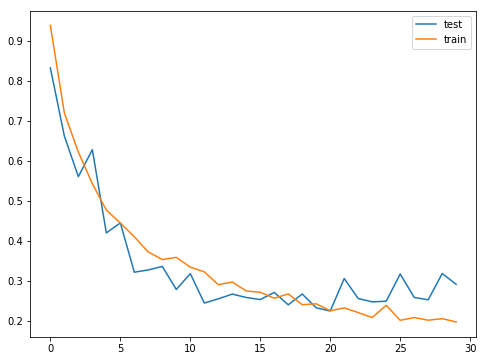

In [65]:
perf = model_smote.history.history

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perf['val_loss'], label='test')
ax.plot(perf['loss'], label='train')
ax.legend();

In [47]:
# def eval_generator(model, train_gen, valid_gen, epochs=10, weights=None):
#     STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
#     STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
#     STEP_SIZE_TEST = test_gen.n//test_gen.batch_size

#     model.evaluate_generator(generator=train_gen,
#                         steps_per_epoch=STEP_SIZE_TRAIN,
#                         validation_data=valid_gen,
#                         validation_steps=STEP_SIZE_VALID,
#                         epochs=epochs, class_weight=weights)

STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
model_smote.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

[0.3095519168829832, 0.9193548391369508]

* Benchmark weights scoring ~92% on validation data. 
* Unclear if weighting classes improves performance wrt unweighted classes. May be helping prevent overfitting.

## Preprocessing 
For preprocessing, in addition to scaling, I'll use rotation, cropping, rescaling, shear_range, zoom_range, flipping, and fill_mode

In [15]:
datagen_prep = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True, 
                                  rotation_range=40, width_shift_range=0.2, 
                                  height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, 
                                  horizontal_flip=True, vertical_flip=True, 
                                  validation_split=0.25
                                 )

train_gen_prep = datagen_prep.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col='image_paths', y_col='defect_type', 
                                              color_mode='grayscale', subset='training', 
                                              batch_size=32, seed=42, shuffle=True,
                                              class_mode='categorical', target_size=(250, 250), 
                                             )

valid_gen_prep = datagen_prep.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col='image_paths', y_col='defect_type', 
                                              color_mode='grayscale', subset='validation', 
                                              batch_size=32, seed=42, shuffle=True,
                                              class_mode='categorical', target_size=(250, 250), 
                                             )

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 19 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3459 validated image filenames belonging to 4 classes.
Found 1153 validated image filenames belonging to 4 classes.


In [ ]:
model_prep = build_cnn_benchmark2()
fit_model(model_prep, train_gen_prep, valid_gen_prep, weights=weights, epochs=3)

Epoch 1/3
108/108 [==============================] - 1572s 15s/step - loss: 1.1022 - acc: 0.5966 - val_loss: 1.0875 - val_acc: 0.6476
Epoch 2/3
 56/108 [==============>...............] - ETA: 10:16 - loss: 0.9831 - acc: 0.6034

**Data Augmentation is not necessary for this problem, given the high volume of available training data, and data collection at SEM module-level is much more standardized than images "in the wild"**

In [ ]:
model_benchmark = build_cnn_benchmark2()
fit_model(model_benchmark, train_generator, valid_generator, weights=weights, epochs=30)

In [10]:
def plot_sample_images(df, image_type='Topography1_Class1', seed=2):
    np.random.seed(seed)
    image_df = df[df.image_type == image_type]
    # masking defect_labels with fewer than 50 images
    defect_counts = image_df.defect_label.value_counts()
    defect_labels = defect_counts[defect_counts > 19].index

    n_labels = len(defect_labels)
    mx, nx = (250, 250)

    fig, rows = plt.subplots(n_labels, n_labels, figsize=(12, 12))

    for i, row in enumerate(rows):
        label = defect_labels[i]
        data = image_df[image_df.defect_label == label].reset_index()
        for ax in row:
            n = np.random.randint(len(data))
            im_file = data['image_paths'][n]
            im = Image.open(im_file).resize((mx, nx))
            ax.imshow(im)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    for ax, row in zip(rows[:, 0], defect_labels):
        ax.set_ylabel(row, size='large')

    plt.suptitle(image_type, size='xx-large', weight='bold')
    plt.subplots_adjust(top=0.93);

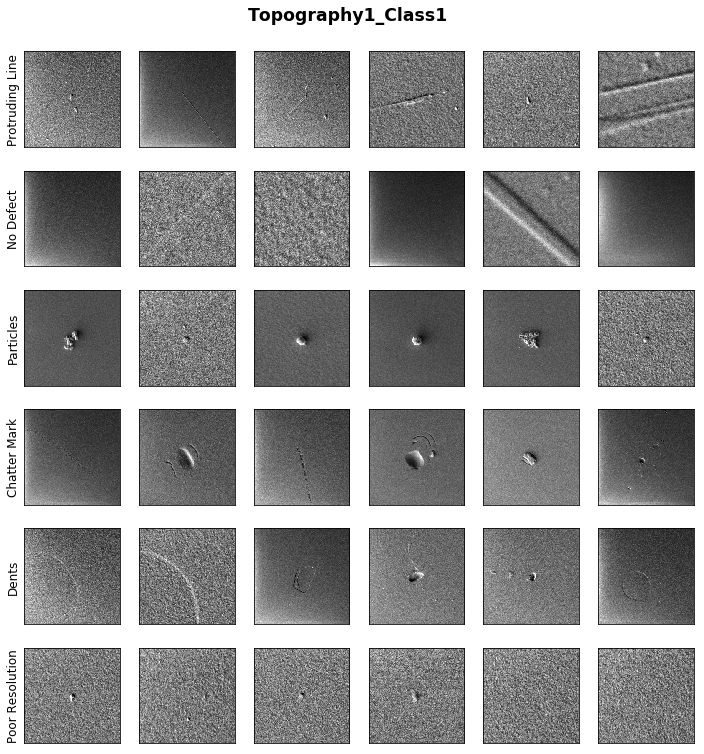

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
plot_sample_images(train_df, seed=4)